---

# BTC Historical Data Analysis and Classification

Bitcoin (BTC), known for its high volatility, presents a unique opportunity for predictive modeling in financial markets. The objective of this notebook is to explore whether machine learning techniques like **Logistic Regression** and **Random Forest Classification** can accurately predict the direction of BTC's price movement based on historical trading data.

The classification task is framed as a binary prediction problem: will the BTC price increase or decrease after a specified number of days (`lookahead_days`)? Success in this task could provide valuable insights for designing trading strategies. However, the inherent complexity and noise in financial data require careful preprocessing, feature engineering, and model selection to achieve meaningful results.

We structure the analysis by first engineering features tailored to capture BTC price patterns, followed by training and evaluating both models. The comparison highlights how logistic regression, a linear model, struggles with non-linear patterns, and why Random Forest, a more flexible algorithm, might offer better performance.

---

## Feature Engineering

The quality of the features used can significantly influence the performance of a predictive model. For this task, we opted to create indicators commonly used in financial analysis, balancing simplicity with effectiveness:

1. **Moving Averages (MA):**
   These smooth out short-term fluctuations in price, helping to capture overall trends. We chose 7, 14, and 30-day windows to provide varying perspectives on price movement over different time frames. This decision ensures both short-term dynamics and broader trends are accounted for.

2. **Relative Strength Index (RSI):**
   RSI measures price momentum, helping identify overbought or oversold conditions. This feature was included to capture scenarios where price reversals might occur. Momentum indicators like RSI often add depth to trend-following features like moving averages.

3. **Bollinger Bands:**
   Volatility plays a critical role in cryptocurrency markets. By incorporating Bollinger Bands, which measure price deviations from a moving average, the model can account for periods of high volatility where prices deviate significantly.

4. **Volume-Based Indicators:**
   Volume can often signal upcoming price changes. A 7-day average of trading volume was chosen to highlight shifts in market activity, complementing price-based features.

These features were selected to provide a comprehensive yet interpretable view of the market. While they are straightforward, they align well with the domain knowledge of financial markets, making them robust starting points for model training.

---

## Dataset Details

The dataset includes key trading metrics such as opening price, closing price, highest and lowest price, and traded volume. We define the target variable as binary: 

- `1` if the BTC price increases after the specified `lookahead_days`.
- `0` if the BTC price decreases.

This simple formulation allows us to focus on evaluating the models' capabilities in capturing price direction rather than precise numerical predictions.

While logistic regression serves as a baseline due to its simplicity and interpretability, the dataset's complexity and the likely presence of non-linear patterns in BTC price movement motivate the inclusion of Random Forest. This approach reflects a progression from understanding fundamental relationships to leveraging a model capable of capturing more intricate interactions.

By iteratively building upon these features and evaluating model performance, we aim to strike a balance between interpretability and predictive power. This process ensures that each decision is deliberate and grounded in the requirements of the task. 

---

### Imports

Import necessary modules.

In [78]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
    

The `load_and_preprocess` function focuses on preparing the raw BTC dataset for analysis and model training by integrating the feature engineering described earlier. It begins by importing the data, standardizing column names, converting dates to a usable format, and sorting the dataset chronologically to maintain the integrity of time-series data.

The primary objective of this function is to apply the predefined feature engineering pipeline—such as calculating moving averages, RSI, Bollinger Bands, and volume-based metrics—while ensuring compatibility for model training. It also defines the binary target variable (`1` for a price increase and `0` for a decrease) using a forward-looking approach based on `lookahead_days`. 

To finalize the preparation, any rows containing null values—introduced during rolling window calculations—are removed, ensuring a clean and complete dataset. This function operationalizes the feature engineering strategy and outputs a dataset ready for training and evaluation.

In [79]:

# Load Data
def load_and_preprocess(csv_path, lookahead_days):
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.lower()
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')

    # Feature Engineering
    df['ma_7day'] = df['close'].rolling(7).mean()
    df['ma_14day'] = df['close'].rolling(14).mean()
    df['ma_30day'] = df['close'].rolling(30).mean()

    # RSI Calculation
    df['price_change'] = df['close'].diff()
    df['gain'] = df['price_change'].clip(lower=0)
    df['loss'] = -1 * df['price_change'].clip(upper=0)
    avg_gain = df['gain'].rolling(14).mean()
    avg_loss = df['loss'].rolling(14).mean()
    rs = avg_gain / avg_loss
    df['rsi'] = 100 - (100 / (1 + rs))

    # Bollinger Bands
    df['bb_middle'] = df['close'].rolling(20).mean()
    df['bb_std'] = df['close'].rolling(20).std()
    df['bb_upper'] = df['bb_middle'] + (2 * df['bb_std'])
    df['bb_lower'] = df['bb_middle'] - (2 * df['bb_std'])

    # Volume-Based Indicators
    df['volume_ma_7day'] = df['volume'].rolling(7).mean()

    # Target Variable
    df['future_close'] = df['close'].shift(-lookahead_days)
    df['target'] = (df['future_close'] > df['close']).astype(int)

    # Drop rows with null values
    df = df.dropna()

    return df

# Dataset Path
csv_path = "../data/raw/btc_usd.csv"
df = load_and_preprocess(csv_path, lookahead_days=7)
    

### Feature Selection
The `feature_columns` list specifies the input features that will be used for model training. These include raw trading data (`open`, `high`, `low`, `volume`) as well as engineered features like moving averages, RSI, Bollinger Bands, and volume-based indicators. These features were chosen to capture a mix of trend, momentum, and volatility signals, providing a comprehensive view of BTC price dynamics. The variable `X` represents the feature set, while `y` holds the binary target variable (`1` for price increase, `0` for decrease).

### Train-Test Split
The data is split into two subsets:
- **Training Set (`X_train`, `y_train`)**: Used for training the model, comprising 70% of the data.
- **Testing Set (`X_test`, `y_test`)**: Used to evaluate model performance on unseen data, comprising the remaining 30%.

The `random_state` parameter ensures that the split is reproducible, maintaining consistent results across runs. Splitting the data helps evaluate the model's ability to generalize rather than overfit to the training data.

### Feature Scaling
A `StandardScaler` is applied to standardize the feature values. This process centers each feature around a mean of 0 and scales it to have a standard deviation of 1:
- **Training Data (`X_train_scaled`)**: The scaler computes the mean and standard deviation from the training data and scales the features accordingly.
- **Testing Data (`X_test_scaled`)**: The same scaling parameters are applied to the testing data, ensuring consistency.

Feature scaling is crucial for algorithms like Logistic Regression, as it prevents features with larger ranges (e.g., volume) from dominating the learning process, ensuring all features contribute equally.

In [80]:
def train_and_evaluate(df, feature_columns, test_size=0.3, random_state=42):
    """
    Train and evaluate a Logistic Regression model on the given dataset.
    :param df: Preprocessed DataFrame with features and target.
    :param feature_columns: List of feature column names.
    :param test_size: Test set proportion.
    :param random_state: Random seed for reproducibility.
    :return: Logistic Regression model and its metrics.
    """
    # Define Features and Target
    X = df[feature_columns]
    y = df['target']

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Scale Features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train Logistic Regression model
    logistic_model = LogisticRegression(random_state=random_state, max_iter=500)
    logistic_model.fit(X_train_scaled, y_train)

    # Predictions
    y_train_pred = logistic_model.predict(X_train_scaled)
    y_test_pred = logistic_model.predict(X_test_scaled)
    return y_train, y_train_pred, y_test, y_test_pred


## Visualize

In [81]:
def display_results(model_name, y_train, y_train_pred, y_test, y_test_pred):
    """
    Display classification results including accuracy, precision, recall, F1-score, and confusion matrix.
    :param model_name: Name of the model (e.g., "Logistic Regression")
    :param y_train: True labels for training set
    :param y_train_pred: Predicted labels for training set
    :param y_test: True labels for test set
    :param y_test_pred: Predicted labels for test set
    """
    # Metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    cm = confusion_matrix(y_test, y_test_pred)

    # Print Results
    print(f"Results for {model_name}:")
    print(f"Training Accuracy: {train_accuracy:.2f}")
    print(f"Testing Accuracy: {test_accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("\nConfusion Matrix:")
    print(cm)

    # Visualize Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Decrease', 'Increase'], yticklabels=['Decrease', 'Increase'])
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()



## Experiment: Increasing the Lookahead Timeframe

In this section, we explore the impact of varying the `lookahead_days` parameter on the model's performance. By increasing the lookahead period, we aim to observe how the model handles changes in the prediction window and whether it affects the accuracy, precision, recall, and other metrics.
    

In [82]:
# Experiment with different lookahead periods
csv_path = "../data/raw/btc_usd.csv"

feature_columns = [
    'open', 'high', 'low', 'volume',
    'ma_7day', 'ma_14day', 'ma_30day', 'rsi',
    'bb_upper', 'bb_lower', 'bb_middle', 'volume_ma_7day'
]


Evaluating for lookahead_days = 7
Results for Logistic Regression:
Training Accuracy: 0.56
Testing Accuracy: 0.55
Precision: 0.56
Recall: 0.87
F1 Score: 0.69

Confusion Matrix:
[[ 77 415]
 [ 79 538]]


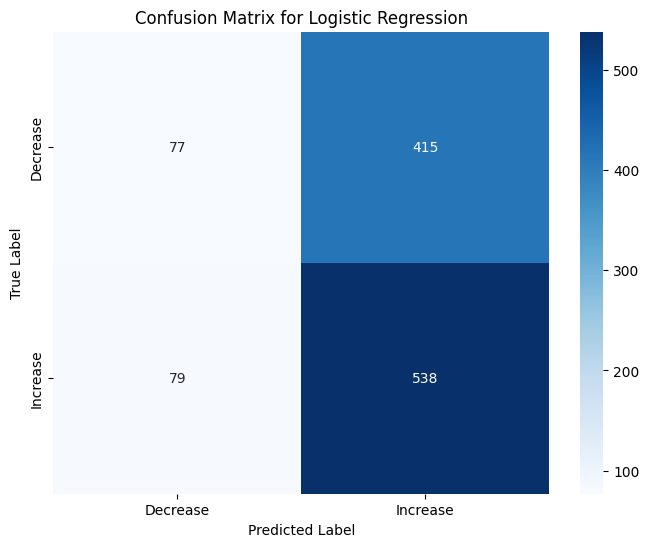

In [83]:
print(f"\nEvaluating for lookahead_days = 7")
df = load_and_preprocess(csv_path, lookahead_days=7)
y_train, y_train_pred, y_test, y_test_pred = train_and_evaluate(df, feature_columns=feature_columns)
display_results(
    model_name="Logistic Regression",
    y_train=y_train,
    y_train_pred=y_train_pred,
    y_test=y_test,
    y_test_pred=y_test_pred,
)


Evaluating for lookahead_days = 14
Results for Logistic Regression:
Training Accuracy: 0.58
Testing Accuracy: 0.56
Precision: 0.57
Recall: 0.85
F1 Score: 0.68

Confusion Matrix:
[[ 95 391]
 [ 95 526]]


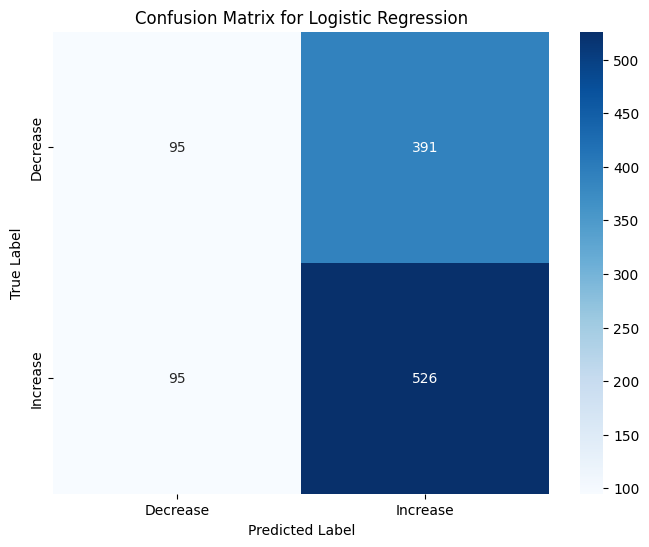

In [84]:
print(f"\nEvaluating for lookahead_days = 14")
df = load_and_preprocess(csv_path, lookahead_days=14)
y_train, y_train_pred, y_test, y_test_pred = train_and_evaluate(df, feature_columns=feature_columns)
display_results(
    model_name="Logistic Regression",
    y_train=y_train,
    y_train_pred=y_train_pred,
    y_test=y_test,
    y_test_pred=y_test_pred,
)


Evaluating for lookahead_days = 30
Results for Logistic Regression:
Training Accuracy: 0.60
Testing Accuracy: 0.59
Precision: 0.60
Recall: 0.88
F1 Score: 0.71

Confusion Matrix:
[[ 91 374]
 [ 79 558]]


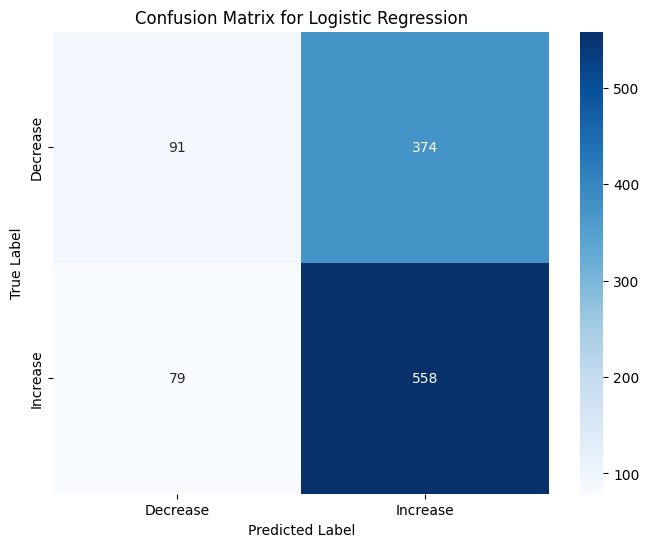

In [85]:
print(f"\nEvaluating for lookahead_days = 30")
df = load_and_preprocess(csv_path, lookahead_days=30)
y_train, y_train_pred, y_test, y_test_pred = train_and_evaluate(df, feature_columns=feature_columns)
display_results(
    model_name="Logistic Regression",
    y_train=y_train,
    y_train_pred=y_train_pred,
    y_test=y_test,
    y_test_pred=y_test_pred,
)


Evaluating for lookahead_days = 60
Results for Logistic Regression:
Training Accuracy: 0.61
Testing Accuracy: 0.62
Precision: 0.63
Recall: 0.86
F1 Score: 0.73

Confusion Matrix:
[[117 326]
 [ 89 561]]


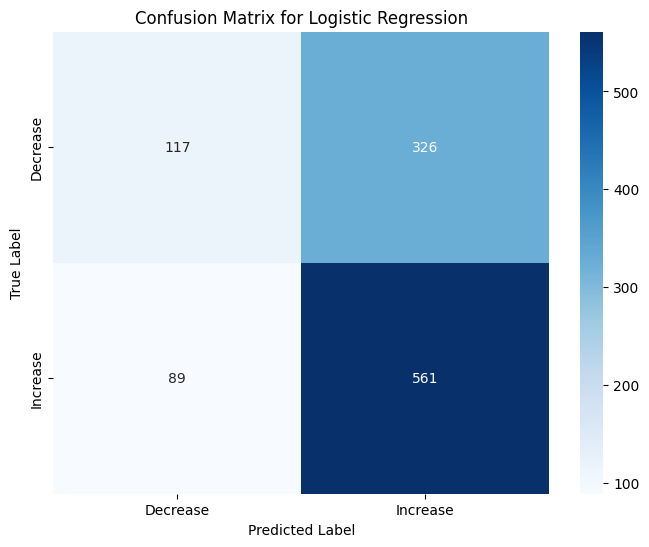

In [86]:
print(f"\nEvaluating for lookahead_days = 60")
df = load_and_preprocess(csv_path, lookahead_days=60)
y_train, y_train_pred, y_test, y_test_pred = train_and_evaluate(df, feature_columns=feature_columns)
display_results(
    model_name="Logistic Regression",
    y_train=y_train,
    y_train_pred=y_train_pred,
    y_test=y_test,
    y_test_pred=y_test_pred,
)

### Logistic Regression

Logistic regression is chosen as a baseline model for this classification task due to its simplicity and interpretability. It assumes a linear relationship between the features and the log-odds of the target variable, making it a good starting point to understand how the features influence the outcome. The model is instantiated with a fixed random seed (`random_state=42`) for consistent results and a maximum iteration limit (`max_iter=500`) to ensure convergence during optimization.


---

### Predictions

Once trained, the logistic regression model is used to make predictions:
- **Training Set Predictions**: The model predicts outcomes for the training set (`logistic_y_train_pred`) to assess how well it has captured patterns in the data it was trained on.
- **Testing Set Predictions**: Predictions on the testing set (`logistic_y_test_pred`) are used to evaluate how well the model generalizes to unseen data.

This dual evaluation provides a clearer picture of both overfitting and generalization performance.

---

### Metrics Calculation

To evaluate the logistic regression model, a range of metrics is computed:
- **Training Accuracy**: Measures how well the model fits the training data. High accuracy here could indicate a strong fit, but overly high accuracy relative to testing accuracy might signal overfitting.
- **Testing Accuracy**: Assesses the model's ability to generalize to unseen data, a critical factor in financial applications like BTC price prediction.
- **Precision**: Indicates the quality of positive predictions. In financial tasks, precision can be important when false positives carry a high cost (e.g., predicting price increases that do not occur).
- **Recall**: Reflects the model's ability to identify actual positive cases. In scenarios where missing opportunities (e.g., failing to predict a price increase) is costly, recall becomes vital.
- **F1 Score**: Provides a balanced view of precision and recall, especially useful when there’s an imbalance between classes.
- **Confusion Matrix**: Summarizes the prediction results into true positives, true negatives, false positives, and false negatives. This helps in understanding the types of errors the model is making.

---

### Thoughts on Logistic Regression

Logistic regression is a strong baseline model, but it may struggle in capturing non-linear relationships and complex interactions between features, which are often present in financial datasets like BTC price movements. The results from this model will provide a benchmark to compare against more complex models, such as Random Forest, which can better handle non-linearities and feature interactions. This decision-making process ensures that the progression from simple to complex models is logical and data-driven.

### Final Analysis: Insights from Lookahead Experiments 

---

### Observations from Lookahead Experiments

#### Results Summary:

| Lookahead Days | Training Accuracy | Testing Accuracy | Precision | Recall | F1 Score |
|----------------|-------------------|------------------|-----------|--------|----------|
| 7              | 0.56              | 0.55             | 0.56      | 0.87   | 0.69     |
| 14             | 0.58              | 0.56             | 0.57      | 0.85   | 0.68     |
| 30             | 0.60              | 0.59             | 0.60      | 0.88   | 0.71     |
| 60             | 0.61              | 0.62             | 0.63      | 0.86   | 0.73     |

#### Key Takeaways:
1. **Performance Trends**:
   - As the lookahead period increases, testing accuracy and F1 score show gradual improvement.
   - This indicates that longer timeframes mitigate short-term noise, allowing the model to detect more stable price movement patterns.
   - However, even with extended lookahead periods, the model's testing accuracy remains relatively low, suggesting limitations in capturing the complexity of BTC price dynamics.

2. **Confusion Matrix Insights**:
   - Across all lookahead periods, the model consistently predicts price increases (`1`) better than decreases (`0`).
   - High recall for the positive class (`1`) highlights the model's bias toward predicting price increases, but precision remains moderate, leading to frequent false positives.

3. **Persistent Challenges**:
   - The model struggles with correctly identifying price decreases (`0`), as reflected in low true negatives and a high number of false positives in the confusion matrix.
   - This imbalance indicates that logistic regression is not well-suited for the nuanced and often non-linear interactions present in financial data.

---

### Why Logistic Regression Struggles

1. **Linear Assumptions**:
   - Logistic regression assumes linear relationships between features and the target variable.
   - BTC price movements are influenced by non-linear dynamics like momentum shifts, volatility clusters, and sudden market reactions, which cannot be effectively modeled by logistic regression.

2. **Bias Toward Upward Trends**:
   - Features like moving averages and RSI are more sensitive to upward trends, leading to a systematic bias toward predicting price increases (`1`).
   - This bias exacerbates the model's difficulty in accurately predicting price decreases (`0`).

3. **Class Imbalance in Predictions**:
   - Although the target classes (`0` and `1`) are not inherently imbalanced, the model's behavior shows a skew toward the positive class.
   - This results in lower precision and recall for price decreases, particularly in shorter lookahead periods where noise dominates.

---

### Why Random Forest Can Address These Challenges

1. **Non-Linear Capability**:
   - Random Forest can model non-linear relationships and complex feature interactions, which are prevalent in BTC price data.
   - This flexibility allows it to capture patterns that logistic regression inherently misses.

2. **Feature Interactions**:
   - Random Forest can naturally account for interactions between features like RSI, Bollinger Bands, and moving averages, enhancing its ability to distinguish between price increases and decreases.

3. **Robustness to Noise**:
   - By aggregating predictions from multiple decision trees, Random Forest reduces overfitting to noisy patterns, making it more reliable in volatile markets.

4. **Improved Balance**:
   - With proper hyperparameter tuning (e.g., class weights, number of trees), Random Forest can balance predictions between classes, improving both precision and recall for price decreases (`0`).

---

### Next Steps: Transition to Random Forest

1. **Implement Random Forest**:
   - Train and evaluate a Random Forest model using the same dataset and features.
   - Compare its performance against logistic regression across all lookahead periods.

2. **Hyperparameter Tuning**:
   - Explore parameters like the number of estimators, max depth, and class weights to optimize model performance.
   - Consider cross-validation to ensure generalizability.

3. **Feature Importance Analysis**:
   - Leverage Random Forest's feature importance metrics to identify which features contribute most to prediction accuracy.
   - Use this insight to refine feature engineering for further improvements.

4. **Evaluate on Additional Metrics**:
   - Beyond accuracy and F1 score, evaluate metrics like AUC-ROC to assess the model's discrimination ability across all thresholds.

By transitioning to Random Forest, we aim to overcome the limitations of logistic regression and achieve a more balanced and effective prediction model for BTC price movements.